In [1]:
import sys
sys.path.append('..')
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from utils.format_grid import fill_data, cut_data, slice_data, radius_calc
from scipy import stats
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [2]:
sample = 'al_rings'
isNew = True
which_cut = 'isNew' if isNew else 'isBoaz'

samples = {'lifeo': ('LiFeO 43380', '/home/vagrant/jupyter/NDViz/mkilpatr/LiFeO/300K/43380/binned.npz'),
           'al_rings': ('Aluminum 47829', '/home/vagrant/jupyter/StaffScratch/mkilpatr/data/Aluminum/10K/rings/47829/binned.npz'),
           'background': ('Background', '/home/vagrant/jupyter/StaffScratch/mkilpatr/data/Aluminum/10K/no_rings/47378/binned.npz'),
           'al_high_intensity': ('High Intensity Aluminum 48344', '/home/vagrant/jupyter/StaffScratch/mkilpatr/data/Aluminum/10K/high_intensity/48344/binned.npz'),
           'bragg_no_rings': ('Silicon 39362', '/home/vagrant/jupyter/NDViz/mkilpatr/Silicon/300K/39362/binned.npz'),
           'benzil': ('Benzil 23544', '/home/vagrant/jupyter/NDViz/mkilpatr/Benzil/300K/23544/binned.npz'),
           'Cyclosporine': ('Cyclosporine 42580', '/home/vagrant/jupyter/NDViz/mkilpatr/Cyclosporine/300K/42580/binned.npz')}

Path(os.path.join(sample, which_cut)).mkdir(parents = True, exist_ok = True)
# Error message about BPM run 19 is expected because there is no valid data in that run
print(sample)

al_rings


In [3]:
data_ = np.load(samples[sample][1])

In [4]:
def fillData(data_, normMax = False, normAlPeak = False, radius = False):
    axis_label = {'x': 0, 'y': 1, 'z': 2, 'weight': 3}
    
    array = np.zeros(shape=(data_[data_.files[0]].shape[0], 0))
    for i in data_.files:
        array = np.column_stack((array, data_[i]))
        
    if normMax:
        w = np.log(array[:, 3] + 1)
        norm = w / np.max(w)
        array = np.column_stack((array, norm))
        axis_label['normMax'] = array.shape[1] - 1
        
    if normAlPeak:
        w = np.log(array[:, 3] + 1)
        hist, bins = np.histogram(w, bins = 500)
        xvalAl = bins[np.where(hist == hist.max())]
        w = w/xvalAl
        array = np.column_stack((array, w))
        axis_label['normAlPeak'] = array.shape[1] - 1
    
    if radius:
        origin = (0.5, 0.5, 0.5)
        radius = ((array[:,0] - origin[0])**2 + (array[:,1] - origin[1])**2 + (array[:,2] - origin[2])**2) ** 0.5
        array = np.column_stack((array, radius))
        axis_label['radius'] = array.shape[1] - 1
        
    return array, axis_label

In [5]:
data, axis_label = fillData(data_, normMax = True, normAlPeak = True, radius = True)

In [6]:
from numpy.lib.stride_tricks import sliding_window_view

def moving_average(array, n=3):
    array = np.concatenate((np.zeros(shape = (n - 1)), array), axis = 0)
    ret = sliding_window_view(array, n)#[:-n]
    return ret

def scale_factor(array, axis_label, bins = 1000, N = 3):
    hist_r, bins_r = np.histogram(array[:, axis_label['radius']], bins = bins)
    bin_in_r = np.digitize(array[:, axis_label['radius']], bins_r, right=False)
    
    index = 1 + np.linspace(0, bins - 1, bins)
    # rolling mean along last axis
    window = moving_average(hist_r, N)
    mean = np.max(window, axis=1) - np.min(window, axis=1)

    # rolling var/std along last axis
    std = np.max(np.gradient(moving_average(hist_r, N), axis=1), axis = 1)
    std[std < 1.] = 1
    #r = (hist_r.max() - mean)*mean
    r = mean/index
    
    diff = std
    print(bin_in_r)
    print('max(hist_r): {0}, max(std): {1}'.format(hist_r.max(), std.max()))
    # if ratio < 80.:
    #diff = diff/hist_r.max()
    diff = diff*r
    # else:
    # diff = diff/diff.max()
    
    s = float(hist_r.max()/diff.max())
    print('ratio of maxes: ', float(hist_r.max()/diff.max()))
    print('max(diff): ', diff.max())
    mask = diff >= diff.mean()
    diff[mask] = diff.max()*diff[mask]/mean[mask]
    if diff.max() > 1.:
        diff = diff/diff.max()
        
    total_SF = diff[bin_in_r - 2]

    array = np.column_stack((array, total_SF))
    axis_label['scale_factor'] = array.shape[1] - 1
    return array, diff, hist_r, mean, std

In [7]:
cut_dict = {
    'isNew': {str(axis_label['normAlPeak']): (1.5, 9999999.)},
}

sliced_data = data
for k, v in cut_dict[which_cut].items():
    print('Axis {0} cut {1}'.format(k, v))
    sliced_data = slice_data(sliced_data, v, axis = int(k))
    
sliced_data, sf, hist_r, mean, std = scale_factor(sliced_data, axis_label, bins = 2000, N = 15)

Axis 5 cut (1.5, 9999999.0)
[1972 1980 1928 ...    4    9   15]
max(hist_r): 11539, max(std): 2104.0
ratio of maxes:  0.3516881644087204
max(diff):  32810.31654676259


In [8]:
arrays = np.stack((sf, hist_r[:]/hist_r.max()), axis = 0)

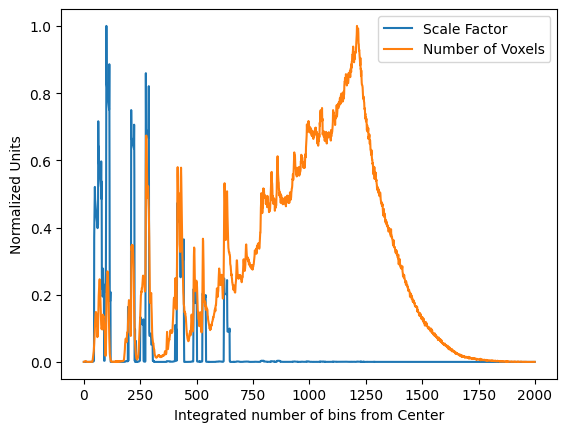

In [9]:
crange = slice(0, 2000)
plt.figure()
plt.plot(sf[crange], label='Scale Factor')
plt.plot(hist_r[crange]/hist_r.max(), label='Number of Voxels')
plt.xlabel('Integrated number of bins from Center')
plt.ylabel('Normalized Units')

plt.legend()
plt.savefig(os.path.join(sample, which_cut, 'scale_factor.png'))
plt.show()

In [10]:
if isNew:
    db = DBSCAN(eps=0.004, 
                min_samples=10, 
                p = 1).fit(sliced_data[:,:3], 
                           sample_weight=sliced_data[:,axis_label['scale_factor']]/sliced_data[:,axis_label['scale_factor']].max())
else:
    db = DBSCAN(eps=0.0035, min_samples=50).fit(sliced_data[:,:3])

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 162
Estimated number of noise points: 5701342


In [11]:
labels_slimmed = np.array(labels)
isCluster = labels_slimmed != -1
c = np.column_stack((sliced_data, labels_slimmed, isCluster))
axis_label['labels'] = c.shape[1] - 2
axis_label['isCluster'] = c.shape[1] - 1
print(c.shape, axis_label)

(6281145, 10) {'x': 0, 'y': 1, 'z': 2, 'weight': 3, 'normMax': 4, 'normAlPeak': 5, 'radius': 6, 'scale_factor': 7, 'labels': 8, 'isCluster': 9}


In [12]:
mask = c[:,axis_label['labels']] >= 0
c = c[mask,:]
print(c.shape)

pca_in = c

(579803, 10)


In [13]:
# import matplotlib as mpl
# viridis = mpl.cm.get_cmap('viridis')
# plt.figure()
# plt.scatter(c[:,axis_label['radius']], c[:,axis_label['normAlPeak']], s = 2.5, c = viridis(c[:,axis_label['scale_factor']]))
# plt.yscale('log')
# plt.colorbar()
# plt.savefig(os.path.join(sample, which_cut, 'intensity_vs_radius.png'))
# plt.show()

In [14]:
from sklearn.decomposition import PCA
dim = 1
pca_latent_space = PCA(n_components=dim,
                       svd_solver='arpack')
pca_out = pca_latent_space.fit_transform(np.column_stack((
                                                          pca_in[:,axis_label['radius']],
                                                          pca_in[:,axis_label['normMax']],
                                                          pca_in[:,axis_label['scale_factor']]/c[:,axis_label['scale_factor']].max(),
                                                          pca_in[:,axis_label['x']],
                                                          pca_in[:,axis_label['y']], 
                                                          pca_in[:,axis_label['z']],
                                                          # pca_in[:,axis_label['p']], 
                                                          # pca_in[:,axis_label['se']], 
                                                         )))

c = np.column_stack((c, pca_out[:,:]))
axis_label['pca2'] = c.shape[1] - 2
axis_label['pca1'] = c.shape[1] - 1

In [15]:
pca_out.shape

(579803, 1)

In [ ]:
import matplotlib as mpl
viridis = mpl.cm.get_cmap('viridis')
plt.figure()
if dim == 1:
    plt.scatter(pca_in[:,axis_label['radius']], pca_out[:,0], s = 2.5, c = viridis(c[:,axis_label['scale_factor']]/c[:,axis_label['scale_factor']].max()))
elif dim == 2:
    plt.scatter(pca_out[:,0], pca_out[:,1], s = 2.5, c = viridis(c[:,axis_label['scale_factor']]/c[:,axis_label['scale_factor']].max()))
plt.colorbar()
plt.yscale('log')
plt.legend(title="PCA " + samples[sample][0])
plt.savefig(os.path.join(sample, which_cut, 'pca_' + str(dim) + 'D.png'))
plt.show()

/tmp/ipykernel_8942/1358716174.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = mpl.cm.get_cmap('viridis')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
isPCA = True
mask = pca_out[:,0] >= 0.07
suffix = '_PCAgt2' if isPCA else '_noPCAcut'
test = c[mask, :] if isPCA else c[:,:]
print(test.shape)

In [ ]:
import matplotlib as mpl
viridis = mpl.cm.get_cmap('viridis')
def plot_scatter(d, xname, yname, log = False, color = 'labels', suffix = ''):
    plt.figure()
    if log:
        plt.scatter(d[:,axis_label[xname]], np.log(d[:,axis_label[yname]]), s = 2.5, c = viridis(d[:,axis_label[color]]/d[:,axis_label[color]].max()))
    else:
        plt.scatter(d[:,axis_label[xname]], d[:,axis_label[yname]], s = 2.5, c = viridis(d[:,axis_label[color]]/d[:,axis_label[color]].max()))
    plt.colorbar()
    plt.legend(title=samples[sample][0])
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.savefig(os.path.join(sample, which_cut, xname + '_vs_' + yname + suffix + '.png'))
    plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
#c = sliced_data

N_color = (0, labels_slimmed.max())
#mask = np.logical_or(test[:,axis_label['slopes']] <= -20, test[:,axis_label['slopes']] > 20.)
mask = np.logical_and(test[:,axis_label['labels']] <= N_color[1], test[:,axis_label['labels']] > N_color[0])
#mask = test[:,axis_label['pca']] <= 25.
print(test.shape)

diff = N_color[1] - N_color[0]

plot_scatter(test[mask,:], 'radius', 'normAlPeak', log = True, color = 'scale_factor', suffix = suffix)
#plot_scatter(test[mask,:], 'radius', 'slopes', log = False)

if test.shape[0] < 500000:
    fig = go.Figure(data =[go.Scatter3d(x=test[mask,0],
                                         y=test[mask,1],
                                         z=test[mask,2],
                                         mode='markers',
                                         marker=dict(
                                             size=1,
                                             color=viridis(test[mask,axis_label['scale_factor']]/test[:,axis_label['scale_factor']].max()),
                                         )
                                       )])
    fig.update_layout(
        title=samples[sample][0],
        scene = dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
        width=800, height=700, autosize=False,
        margin=dict(l=20, r=20, b=20, t=55),
    )
    fig.show()